# 라이브러리

In [22]:
import pandas as pd
import numpy as np

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
total_data = pd.read_csv('total_data.csv')
total_data

,SUBJECT_ID,ITEMID,CHARTTIME,TYPE
0,9,50882,2149-11-09,LAB
1,9,50931,2149-11-09,LAB
2,9,50971,2149-11-09,LAB
3,9,51275,2149-11-09,LAB
4,9,51288,2149-11-09,LAB
...,...,...,...,...
9221915,99985,51288,2181-03-06,LAB
9221916,99985,51279,2182-03-14,LAB
9221917,99985,51006,2182-03-14,LAB
9221918,99985,51221,2182-03-14,LAB


# 환자별 입원 기간에 대한 EDA
## 환자의 입원 기간별 비율 
- min : 0일, max : 4058일(11년)
- 0이상 ~ 100미만 stay : 4967명/7799명 (63.68)
- 100이상 ~ 200미만 stay : 509명/7799명 (6.52)
- 200이상 ~ 300미만 stay : 341명/7799명 (4.37)
- 300이상 ~ 400미만 stay : 417명/7799명 (5.34)
> 0일이상 400일 미만으로 머무른 환자 수는 6234명이며 전체 환자 수의 79.9%이다.

## 0이상 ~ 100미만에 대한 10단위 세분화
- 0이상 ~ 10미만 : 1723명/7799명 (22.0)
- 10이상 20미만 : 1300명/7799명 (16.6)
- 20이상 30미만 : 688명/7799명 (8.82)
- 30이상 40미만 : 425명/7799명 (5.44)

## 장단기 data 후보
- 후보1) interval : 1일, total : 10일 (10) -> 기존의 데이터 / 'x_(7727, 10, 4069).npy'
- 후보2) interval : 2일, total : 20일 (10) -> 'x_int2_(7727, 10, 4069).npy'
- 후보3) interval : 3일, total : 30일 (10) -> 'x_int3_(7727, 10, 4069).npy'
- 후보4) interval : 2일, total : 60일 (30) -> 'x_int2_(7727, 30, 4069).npy'
- 후보5) interval : 3일, total : 90일 (30) -> 'x_int3_(7727, 30, 4069).npy'

In [2]:
import pandas as pd
import numpy as np

total_data = pd.read_csv('total_data.csv')

In [3]:
# stay를 위한 df
import datetime as dt

mn = total_data.pivot_table(columns=['SUBJECT_ID'],values=['CHARTTIME'],aggfunc='min').transpose()
mx = total_data.pivot_table(columns=['SUBJECT_ID'],values=['CHARTTIME'],aggfunc='max').transpose()
datecheck = pd.merge(mn, mx, on='SUBJECT_ID')
datecheck['CHARTTIME_x'] = pd.to_datetime(datecheck['CHARTTIME_x'])
datecheck['CHARTTIME_y'] = pd.to_datetime(datecheck['CHARTTIME_y'])
datecheck['stay']=(datecheck['CHARTTIME_y']-datecheck['CHARTTIME_x']).dt.days
datecheck

,CHARTTIME_x,CHARTTIME_y,stay
SUBJECT_ID,,,
9,2149-11-09,2149-11-15,6
21,2134-08-20,2135-02-08,172
31,2108-08-22,2108-08-31,9
36,2131-04-30,2134-05-20,1116
37,2183-08-21,2184-04-27,250
...,...,...,...
99863,2142-04-02,2142-05-08,36
99934,2110-02-28,2110-03-06,6
99937,2128-05-11,2128-05-20,9


In [4]:
# stay 0~4058일에 대한 10일 단위 구간화 
stay_df = pd.DataFrame(datecheck['stay'])
bins = list(range(0, 4200, 100))
bins_label = [str(x)+"이상 "+str(x+100)+"미만" for x in bins]
stay_df["level"] = pd.cut(stay_df['stay'], bins, right=False, labels=bins_label[:-1])
stay_df

,stay,level
SUBJECT_ID,,
9,6,0이상 100미만
21,172,100이상 200미만
31,9,0이상 100미만
36,1116,1100이상 1200미만
37,250,200이상 300미만
...,...,...
99863,36,0이상 100미만
99934,6,0이상 100미만
99937,9,0이상 100미만


<AxesSubplot:ylabel='Count'>

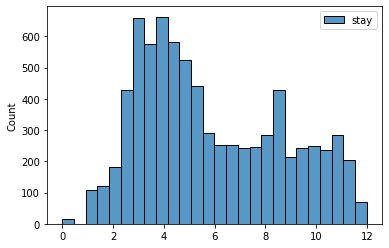

In [14]:
# stay에 따른 count
a = pd.DataFrame(stay_df['stay'])

import seaborn as sns
sns.histplot(a.apply(lambda x: np.log2(x+1)))

In [118]:
# stay 0~100일에 대한 10일 단위 구간화 
stay100 = stay_df[stay_df['level']=='0이상 100미만'].drop(columns='level')
bins = list(range(0, 110, 10))
bins_label = [str(x)+"이상 "+str(x+10)+"미만" for x in bins]
stay100["level"] = pd.cut(stay100['stay'], bins, right=False, labels=bins_label[:-1])
stay100

,stay,level
SUBJECT_ID,,
9,6,0이상 10미만
31,9,0이상 10미만
41,32,30이상 40미만
101,11,10이상 20미만
103,20,20이상 30미만
...,...,...
99836,66,60이상 70미만
99863,36,30이상 40미만
99934,6,0이상 10미만


## 일자별 itemid abnormal 비율
- 마지막에 가까울수록 itemid abnormal 비율이 차이가 날까?
- 특히나 많아지는 날짜? -> 위독한 날짜인가? -> 10일치를 본 이유...

### 10일치 데이터

In [35]:
x = np.load('./x_(7727,10,4069).npy')

In [36]:
ab_rate = x.sum(axis=2)
ab_rate = pd.DataFrame(ab_rate)
ab_rate.columns = ['D-10','D-9','D-8','D-7','D-6',
            'D-5','D-4','D-3','D-2','D-1']
ab_rate

,D-10,D-9,D-8,D-7,D-6,D-5,D-4,D-3,D-2,D-1
0,0.0,0.0,0.0,0.0,0.0,24.0,36.0,35.0,26.0,40.0
1,0.0,13.0,51.0,52.0,46.0,44.0,40.0,47.0,40.0,8.0
2,0.0,0.0,15.0,33.0,36.0,35.0,35.0,35.0,37.0,47.0
3,17.0,27.0,56.0,51.0,45.0,47.0,44.0,30.0,31.0,22.0
4,0.0,0.0,0.0,0.0,0.0,38.0,38.0,45.0,34.0,25.0
...,...,...,...,...,...,...,...,...,...,...
7722,43.0,38.0,40.0,42.0,34.0,35.0,34.0,35.0,35.0,34.0
7723,0.0,0.0,0.0,0.0,39.0,35.0,26.0,29.0,23.0,21.0
7724,0.0,26.0,23.0,21.0,23.0,27.0,28.0,28.0,30.0,27.0
7725,0.0,0.0,0.0,0.0,0.0,29.0,37.0,49.0,46.0,44.0


In [79]:
ab_rate['10~6']=ab_rate.iloc[:,0:5].sum(axis=1)
ab_rate['5~1']=ab_rate.iloc[:,5:].sum(axis=1)
ab_rate['10~6'].mean()
ab_rate['5~1'].mean()

113.61330399896467

528.7231784651223

In [37]:
ab_rate.mean()

D-10    18.892455
D-9     20.683189
D-8     22.835124
D-7     24.646176
D-6     26.556361
D-5     28.360166
D-4     29.974117
D-3     30.854924
D-2     30.969199
D-1     30.589880
dtype: float64

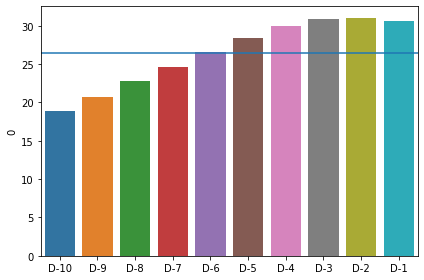

In [40]:
# D-1 ~ D-10별 각 환자의 ITEMID abnormal sum에 대한 평균 
m = pd.DataFrame(ab_rate.mean())

_ = sns.barplot(data=m,x=m.index,y=m[0])
_ = plt.tight_layout()
_ = plt.axhline(y=m.mean().values)

### 30일치 데이터

In [41]:
x_30 = np.load("x_(7727,30,4068).npy")

In [42]:
ab_rate2 = x_30.sum(axis=2)
ab_rate2 = pd.DataFrame(ab_rate2)
ab_rate2.columns = [f'D-{x}' for x in range(30,0,-1)]
ab_rate2

,D-30,D-29,D-28,D-27,D-26,D-25,D-24,D-23,D-22,D-21,...,D-10,D-9,D-8,D-7,D-6,D-5,D-4,D-3,D-2,D-1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,36.0,35.0,26.0,40.0
1,5.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,51.0,52.0,46.0,44.0,40.0,47.0,40.0,8.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,33.0,36.0,35.0,35.0,35.0,37.0,47.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,27.0,56.0,51.0,45.0,47.0,44.0,30.0,31.0,22.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38.0,38.0,45.0,34.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7722,48.0,50.0,45.0,45.0,52.0,53.0,48.0,52.0,54.0,65.0,...,43.0,38.0,40.0,42.0,34.0,35.0,34.0,35.0,35.0,34.0
7723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,39.0,35.0,26.0,29.0,23.0,21.0
7724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,26.0,23.0,21.0,23.0,27.0,28.0,28.0,30.0,27.0
7725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,29.0,37.0,49.0,46.0,44.0


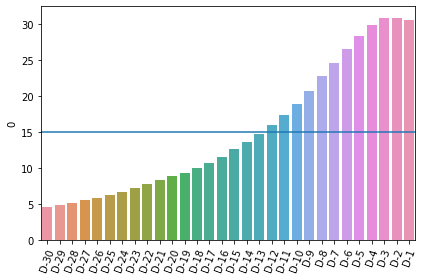

In [43]:
# D-1 ~ D-30별 각 환자의 ITEMID abnormal sum에 대한 평균 
m = pd.DataFrame(ab_rate2.mean())

_ = sns.barplot(data=m,x=m.index,y=m[0])
_ = plt.xticks(rotation=70)
_ = plt.tight_layout()
_ = plt.axhline(y=m.mean().values)

In [ ]:
# ab_rate2['1~5']=ab_rate2.iloc[:,-5:].sum(axis=1)
# ab_rate2['6~10']=ab_rate2.iloc[:,-10:-5].sum(axis=1)
# ab_rate2['11~15']=ab_rate2.iloc[:,-15:-10].sum(axis=1)
# ab_rate2['16~20']=ab_rate2.iloc[:,-20:-15].sum(axis=1)
# ab_rate2['21~25']=ab_rate2.iloc[:,-25:-20].sum(axis=1)
# ab_rate2['26~30']=ab_rate2.iloc[:,0:5].sum(axis=1)

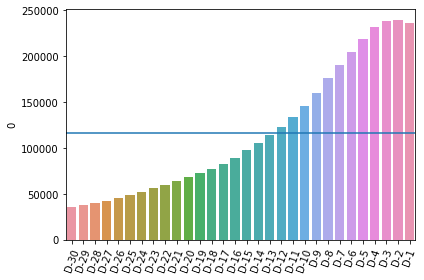

In [53]:
# D-1 ~ D-30별 환자들의 ITEMID abnormal sum 계산
s1 = pd.DataFrame(ab_rate2.sum())

_ = sns.barplot(data=s1,x=s1.index,y=s1[0])
_ = plt.xticks(rotation=70)
_ = plt.tight_layout()
_ = plt.axhline(y=s1.mean().values)

In [65]:
# 환자들의 ITEMID abnormal sum의 구간별 비율
(s1.iloc[0:10,:].sum()/s1.sum()) * 100  # D-21 ~ D-30의 sum
(s1.iloc[10:20,:].sum()/s1.sum()) * 100 # D-11 ~ D-20의 sum
(s1.iloc[20:30,:].sum()/s1.sum()) * 100 # D-1 ~ D-10의 sum 

0    13.81762
dtype: float64

0    27.596637
dtype: float64

0    58.585743
dtype: float64

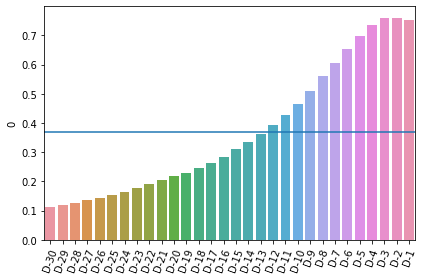

In [52]:
# D-1 ~ D-30별 환자들의 ( ITEMID abnormal sum / 7727 * 4068 ) * 100 ⇒ 비율 계산
sum_rate = pd.DataFrame((ab_rate2.sum()/(7727*4068))*100)

_ = sns.barplot(data=sum_rate,x=sum_rate.index,y=sum_rate[0])
_ = plt.xticks(rotation=70)
_ = plt.tight_layout()
_ = plt.axhline(y=sum_rate.mean().values)

# 7727명만을 포함한 total_data_7727.csv

In [77]:
# total_data.csv -> 7727명을 포함한 total_data.csv
x = np.load('./x_(7799,10,4069).npy')

sub_sum = x.sum(axis=1).sum(axis=1)
sub_sum[sub_sum>1] = 1
sub_sum = pd.DataFrame(sub_sum)
sub_sum = sub_sum.reset_index()
sub_sum.columns = ['subid','value']
# sub_sum

zero_index = sub_sum[sub_sum['value']==0].index
sub_df = pd.DataFrame(total_data['SUBJECT_ID'].unique())
sub_df = sub_df.drop(index=zero_index)
subid_7727 = sub_df[0].values
# subid_7727

total_data = pd.read_csv('total_data.csv')
total_data2 = total_data[total_data['SUBJECT_ID'].isin(subid_7727)]
total_data2

# total_data2 -> csv로 저장
# total_data2.to_csv('total_data_7727.csv', index=False)

,SUBJECT_ID,ITEMID,CHARTTIME,TYPE
0,9,50882,2149-11-09,LAB
1,9,50931,2149-11-09,LAB
2,9,50971,2149-11-09,LAB
3,9,51275,2149-11-09,LAB
4,9,51288,2149-11-09,LAB
...,...,...,...,...
9221915,99985,51288,2181-03-06,LAB
9221916,99985,51279,2182-03-14,LAB
9221917,99985,51006,2182-03-14,LAB
9221918,99985,51221,2182-03-14,LAB


# x_(7727,10,4068)

In [6]:
total_data2 = pd.read_csv('./total_data_7727.csv')
total_data = pd.read_csv('./total_data.csv')

dic_sub2idx = {}
for i, j in enumerate(total_data2['SUBJECT_ID'].unique()):
    dic_sub2idx[j] = i

dic_item2idx = {}
for i, j in enumerate(total_data2['ITEMID'].sort_values().unique()): ## total_data2의 ITEMID 개수 : 4068개 
    dic_item2idx[j] = i

admission = pd.read_csv('/project/data/ADMISSIONS.csv')
admission = admission[admission['SUBJECT_ID'].isin(total_data2['SUBJECT_ID'].unique())]

# DISCHTIME열 시간 제거
import datetime as dt
admission['DISCHTIME'] = pd.to_datetime(admission['DISCHTIME'])
admission['DISCHTIME'] = admission['DISCHTIME'].dt.date

dic_sub2final_date = dict(admission.groupby('SUBJECT_ID')['DISCHTIME'].max())

len(dic_sub2idx)
len(dic_item2idx)
len(dic_sub2final_date)

7727

4068

7727

In [7]:
from datetime import timedelta
from tqdm import tqdm
import datetime

x = np.zeros((7727,10,4068))

IF = open('total_data_7727.csv','r')
line = IF.readline()
for line in tqdm(IF):
    ss = line.strip('\n').split(',')
    sub, item, charttime = int(ss[0]), int(ss[1]), datetime.date.fromisoformat(ss[2])
    subidx = dic_sub2idx[sub]
    itemidx = dic_item2idx[item]
    finaldate = dic_sub2final_date[sub]
    interval = (finaldate - charttime).days
    
    if (interval < 1) or (interval > 10): # interval : 1일이상 ~ 10일이하만 고려 
        pass
    else:
        dateidx = -((finaldate - charttime).days) + 10
        x[subidx, dateidx, itemidx] = 1

IF.close()
print(x.sum())
print(x.shape)

9169855it [00:14, 643400.42it/s]


2042722.0
(7727, 10, 4068)


In [8]:
# x save
np.save('x_(7727,10,4068).npy',x)
 
# x load
x_4068 = np.load("x_(7727,10,4068).npy")

In [10]:
x_4068.sum()

2042722.0

# int = 1, total = 10 (len = 10)
- 'x_(7727, 10, 4069).npy'로 저장

In [82]:
total_data2 = pd.read_csv('./total_data_7727.csv')
total_data = pd.read_csv('./total_data.csv')

dic_sub2idx = {}
for i, j in enumerate(total_data2['SUBJECT_ID'].unique()):
    dic_sub2idx[j] = i

dic_item2idx = {}
for i, j in enumerate(total_data['ITEMID'].sort_values().unique()): ## total_data2의 ITEMID 개수 : 4068개 
    dic_item2idx[j] = i

admission = pd.read_csv('/project/data/ADMISSIONS.csv')
admission = admission[admission['SUBJECT_ID'].isin(total_data2['SUBJECT_ID'].unique())]

# DISCHTIME열 시간 제거
import datetime as dt
admission['DISCHTIME'] = pd.to_datetime(admission['DISCHTIME'])
admission['DISCHTIME'] = admission['DISCHTIME'].dt.date

dic_sub2final_date = dict(admission.groupby('SUBJECT_ID')['DISCHTIME'].max())

len(dic_sub2idx)
len(dic_item2idx)
len(dic_sub2final_date)

7727

4069

7727

In [121]:
from datetime import timedelta
from tqdm import tqdm
import datetime

x = np.zeros((7727,10,4069))

IF = open('total_data_7727.csv','r')
line = IF.readline()
for line in tqdm(IF):
    ss = line.strip('\n').split(',')
    sub, item, charttime = int(ss[0]), int(ss[1]), datetime.date.fromisoformat(ss[2])
    subidx = dic_sub2idx[sub]
    itemidx = dic_item2idx[item]
    finaldate = dic_sub2final_date[sub]
    interval = (finaldate - charttime).days
    
    if (interval < 1) or (interval > 10): # interval : 1일이상 ~ 10일이하만 고려 
        pass
    else:
        dateidx = -((finaldate - charttime).days) + 10
        x[subidx, dateidx, itemidx] = 1

IF.close()
print(x.sum())
print(x.shape)

9169855it [00:14, 623455.64it/s]


2042722.0
(7727, 10, 4069)


In [122]:
# 기존에 만든 것과 sum이 같은지 확인 
t = np.load('x_(7727,10,4069).npy')
t.sum()

2042722.0

# int = 1, total = 30 (len = 30)

In [2]:
total_data2 = pd.read_csv('./total_data_7727.csv')

dic_sub2idx = {}
for i, j in enumerate(total_data2['SUBJECT_ID'].unique()):
    dic_sub2idx[j] = i

dic_item2idx = {}
for i, j in enumerate(total_data2['ITEMID'].sort_values().unique()): ## total_data2의 ITEMID 개수 : 4068개 
    dic_item2idx[j] = i

admission = pd.read_csv('/project/data/ADMISSIONS.csv')
admission = admission[admission['SUBJECT_ID'].isin(total_data2['SUBJECT_ID'].unique())]

# DISCHTIME열 시간 제거
import datetime as dt
admission['DISCHTIME'] = pd.to_datetime(admission['DISCHTIME'])
admission['DISCHTIME'] = admission['DISCHTIME'].dt.date

dic_sub2final_date = dict(admission.groupby('SUBJECT_ID')['DISCHTIME'].max())

len(dic_sub2idx)
len(dic_item2idx)
len(dic_sub2final_date)

7727

4068

7727

- ★ 계산 note 
- dateidx = -(finaldate - charttime).days + 10
- (D-?) 0 ( 1 2 3 4 5 6 7 8 9 10 )
- (arr_index) 10 ( 9 8 7 6 5 4 3 2 1 0 )


- dateidx = -((finaldate - charttime).days) + 30
- (D-?) = 0 ( 1 2 3 4 5 ... 27 28 29 30 )
- (arr_index) = 10 ( 29 28 27 26 25 ... 4 3 2 1 0 )

In [4]:
from datetime import timedelta
from tqdm import tqdm
import datetime

x = np.zeros((7727,30,4068))

IF = open('total_data_7727.csv','r')
line = IF.readline()
for line in tqdm(IF):
    ss = line.strip('\n').split(',')
    sub, item, charttime = int(ss[0]), int(ss[1]), datetime.date.fromisoformat(ss[2])
    subidx = dic_sub2idx[sub]
    itemidx = dic_item2idx[item]
    finaldate = dic_sub2final_date[sub]
    interval = (finaldate - charttime).days
    
    if (interval < 1) or (interval > 30): # interval : 1일이상 ~ 30일이하만 고려 
        pass
    else:
        dateidx = -((finaldate - charttime).days) + 30
        x[subidx, dateidx, itemidx] = 1

IF.close()
print(x.sum())
print(x.shape)

9169855it [00:15, 595003.89it/s]


3486722.0
(7727, 30, 4068)


In [5]:
# x save
# np.save('x_(7727,30,4068).npy',x)
 
# x load
x_30 = np.load("x_(7727,30,4068).npy")

# int = 2, total = 20 (len = 10)
- 'x_int2_(7727, 10, 4069).npy'로 저장
- 7727명 중 data가 하나도 없는 환자 : 196명

- ★ 계산 note 
- dateidx = -(finaldate - charttime).days + 10
- (D-?) 0 ( 1 2 3 4 5 6 7 8 9 10 )
- (arr_index) 10 ( 9 8 7 6 5 4 3 2 1 0 )


- dateidx = -((finaldate - charttime).days)//2 + 10
- (finaldate - charttime) % 2 == 0 => 조건추가
- (D-?) = 0 ( 2 4 6 8 10 12 14 16 18 20 )
- (arr_index) = 10 ( 9 8 7 6 5 4 3 2 1 0 )

In [142]:
from datetime import timedelta
from tqdm import tqdm
import datetime

x = np.zeros((7727,10,4069))

IF = open('total_data_7727.csv','r')
line = IF.readline()
for line in tqdm(IF):
    ss = line.strip('\n').split(',')
    sub, item, charttime = int(ss[0]), int(ss[1]), datetime.date.fromisoformat(ss[2])
    subidx = dic_sub2idx[sub]
    itemidx = dic_item2idx[item]
    finaldate = dic_sub2final_date[sub]
    interval = (finaldate - charttime).days
    
    if (interval < 2) or (interval > 20): # interval : 2일이상 ~ 20일이하만 고려 
        pass
    else:
        if ((interval % 2) == 0):
            dateidx = -((finaldate - charttime).days)//2 + 10
            x[subidx, dateidx, itemidx] = 1

IF.close()
print(x.sum())
print(x.shape)

9169855it [00:14, 617069.65it/s]


1461410.0
(7727, 10, 4069)


In [6]:
# x save
# np.save('x_int2_(7727,10,4069).npy',x)

# x load
x_int2 = np.load("./data/x_int2_(7727,10,4069).npy")

# int = 3, total = 30 (len = 10)
- 'x_int3_(7727, 10, 4069).npy'로 저장

In [15]:
from datetime import timedelta
from tqdm import tqdm
import datetime

x = np.zeros((7727,10,4069))

IF = open('./data/total_data_7727.csv','r')
line = IF.readline()
for line in tqdm(IF):
    ss = line.strip('\n').split(',')
    sub, item, charttime = int(ss[0]), int(ss[1]), datetime.date.fromisoformat(ss[2])
    subidx = dic_sub2idx[sub]
    itemidx = dic_item2idx[item]
    finaldate = dic_sub2final_date[sub]
    interval = (finaldate - charttime).days
    
    if (interval < 3) or (interval > 30): # interval : 3일이상 ~ 30일이하만 고려 
        pass
    else:
        if ((interval % 3) == 0):
            dateidx = -((finaldate - charttime).days)//3 + 10
            x[subidx, dateidx, itemidx] = 1

IF.close()
print(x.sum())
print(x.shape)

9169855it [00:14, 635707.73it/s]


1095557.0
(7727, 10, 4069)


In [16]:
# x save
np.save('x_int3_(7727,10,4069).npy',x)

# x load
x_int2 = np.load("./data/x_int3_(7727,10,4069).npy")
x_int2.sum()

ValueError: cannot reshape array of size 0 into shape (7727,10,4069)

# int = 2, total = 60 (len = 30)
- 'x_int2_(7727,30,4069).npy'로 저장

- ★ 계산 note 
- dateidx = -(finaldate - charttime).days + 10
- (D-?) 0 ( 1 2 3 4 5 6 7 8 9 10 )
- (arr_index) 10 ( 9 8 7 6 5 4 3 2 1 0 )


- dateidx = -((finaldate - charttime).days)//2 + 30
- (finaldate - charttime) % 2 == 0 => 조건추가
- (D-?) = 0 ( 2 4 6 8 10 12 14 16 18 20 ... 58 60 )
- (arr_index) = 30 ( 29 28 27 26 25 24 ... 3 2 1 0 )

In [141]:
from datetime import timedelta
from tqdm import tqdm
import datetime

x = np.zeros((7727,30,4069))

IF = open('total_data_7727.csv','r')
line = IF.readline()
for line in tqdm(IF):
    ss = line.strip('\n').split(',')
    sub, item, charttime = int(ss[0]), int(ss[1]), datetime.date.fromisoformat(ss[2])
    subidx = dic_sub2idx[sub]
    itemidx = dic_item2idx[item]
    finaldate = dic_sub2final_date[sub]
    interval = (finaldate - charttime).days
    
    if (interval < 2) or (interval > 60): # interval : 2일이상 ~ 60일이하만 고려 
        pass
    else:
        if ((interval % 2) == 0):
            dateidx = -((finaldate - charttime).days)//2 + 30
            x[subidx, dateidx, itemidx] = 1

IF.close()
print(x.sum())
print(x.shape)

9169855it [00:15, 591364.86it/s]


1986925.0
(7727, 30, 4069)


In [3]:
# x save
# np.save('x_int2_(7727,30,4069).npy',x)

# x load
x_int2_30 = np.load("./data/x_int2_(7727,30,4069).npy")

# int = 3, total = 90 (len = 30)
- 'x_int3_(7727, 30, 4069).npy'로 저장

- ★ 계산 note 
- dateidx = -(finaldate - charttime).days + 10
- (D-?) 0 ( 1 2 3 4 5 6 7 8 9 10 )
- (arr_index) 10 ( 9 8 7 6 5 4 3 2 1 0 )


- dateidx = -((finaldate - charttime).days)//3 + 30
- (finaldate - charttime) % 3 == 0 => 조건추가
- (D-?) = 0 ( 3 6 9 12 15 ... 87 90 )
- (arr_index) = 30 ( 29 28 27 26 25 24 ... 3 2 1 0 )

In [140]:
from datetime import timedelta
from tqdm import tqdm
import datetime

x = np.zeros((7727,30,4069))

IF = open('total_data_7727.csv','r')
line = IF.readline()
for line in tqdm(IF):
    ss = line.strip('\n').split(',')
    sub, item, charttime = int(ss[0]), int(ss[1]), datetime.date.fromisoformat(ss[2])
    subidx = dic_sub2idx[sub]
    itemidx = dic_item2idx[item]
    finaldate = dic_sub2final_date[sub]
    interval = (finaldate - charttime).days
    
    if (interval < 3) or (interval > 90): # interval : 3일이상 ~ 90일이하만 고려 
        pass
    else:
        if ((interval % 3) == 0):
            dateidx = -((finaldate - charttime).days)//3 + 30
            x[subidx, dateidx, itemidx] = 1

IF.close()
print(x.sum())
print(x.shape)

9169855it [00:14, 617086.22it/s]


1380745.0
(7727, 30, 4069)
